# BCM learning rule

The goal of this notebook is to investigate the Intrator & Cooper BCM learning rule for rate-coded networks. 

$$\Delta w = \eta \, r^\text{pre} \, r^\text{post}  \,  (r^\text{post} - \mathbb{E}[(r^\text{post})^2])$$

> Intrator, N., & Cooper, L. N. (1992). Objective function formulation of the BCM theory of visual cortical plasticity: Statistical connections, stability conditions. Neural Networks, 5(1), 3–17. https://doi.org/10.1016/S0893-6080(05)80003-6


In [ ]:
!pip install ANNarchy

We can now import ANNarchy:

In [1]:
from ANNarchy import *
clear()
setup(dt=1.0)

ANNarchy 4.7 (4.7.1.5) on darwin (posix).


We will keep a minimal experimental setup, with two input neurons connected to a single output neuron. Note how the input neurons are defined by setting `r` as a parameter that can be set externally.

In [2]:
# Input
input_neuron = Neuron(
    parameters = """
        r = 0.0
    """
)
pre = Population(2, input_neuron)

# Output
neuron = Neuron(
    equations = """
        r = sum(exc)
    """
)
post = Population(1, neuron)

We can now define a synapse model implementing the Intrator and Cooper version of the BCM learning rule.

The synapse has two parameters: The learning rate `eta` and the time constant `tau` of the moving average `theta`. Both are defined as `projection` parameters, as we only need one value for the whole projection. If you omit this flag, there will be one value per synapse, which would be a waste of RAM.

The moving average `theta` tracks the square of the post-synaptic firing rate `post.r`. It has the flag `postsynaptic`, as we need to compute only one variable per post-synaptic neuron (it does not really matter in our example as have only one output neuron...). It uses the exponential numerical method, as it is a first-order linear ODE that can be solved exactly. However, the default explicit Euler method would work just as well here.

The weight change `dw/dt` follows the BCM learning rule. `min=0.0` ensures that the weight `w` stays positive throughout learning. The `explicit` Euler method is the default and could be omitted.

The `psp` argument `w * pre.r` (what is summed by the post-synaptic neuron over its incoming connections) is also the default value and could be omitted.

In [3]:
IBCM = Synapse(
    parameters = """
        eta = 0.01 : projection
        tau = 100.0 : projection
    """,
    equations = """
        tau * dtheta/dt + theta = (post.r)^2 : postsynaptic, exponential

        dw/dt = eta * post.r * (post.r - theta) * pre.r : min=0.0, explicit
    """,
    psp = "w * pre.r"
)

We can now create a projection between the two populations using the synapse type. The connection method is all-to-all, initialozing the two weights to 1.

In [4]:
proj = Projection(pre, post, 'exc', IBCM)
proj.connect_all_to_all(1.0)

We can now compile the network and record the post-synaptic firing rate as well as the evolution of the weights and thresholds during learning. 

In [5]:
compile()

m = Monitor(post, 'r')
n = Monitor(proj, ['w', 'theta'])

Compiling ...  OK 


The simulation protocol is kept simple, as it consists of setting constant firing rates for the two input neurons and simulating for one second.

In [6]:
pre.r = np.array([1.0, 0.1])
simulate(1000.)

We can now retrieve the recordings and plot the evolution of the various variables.

In [7]:
r = m.get('r')
w = n.get('w')
theta = n.get('theta')

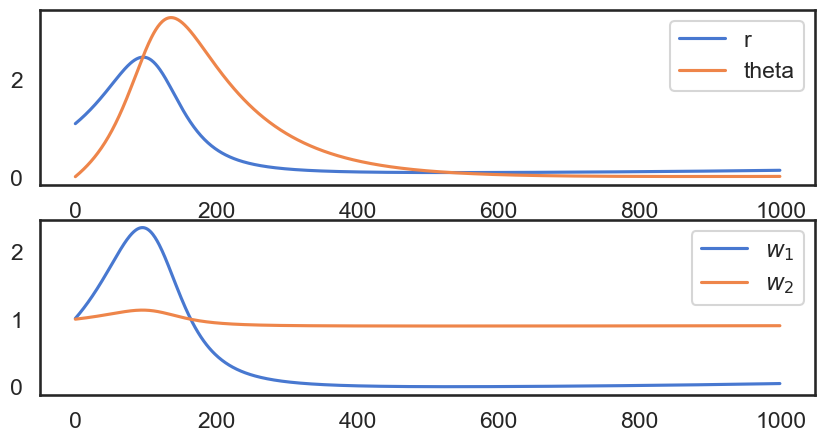

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white", palette="muted", color_codes=True)
sns.set_context("talk")

plt.figure(figsize=(10, 5))
plt.subplot(211)
plt.plot(r[:, 0], label='r')
plt.plot(theta[:, 0], label='theta')
plt.legend()
plt.subplot(212)
plt.plot(w[:, 0, 0], label="$w_1$")
plt.plot(w[:, 0, 1], label="$w_2$")
plt.legend()
plt.show()

Notice how the first weight increases when r is higher than theta (LTP), but decreases afterwards (LTD). Unintuitively, the input neuron with the highest activity sees its weight decreased at the end of the stimulation.